In [1]:
import spacy
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn import model_selection, naive_bayes, svm
from collections import Counter

In [2]:
data = pd.read_csv("hotel_data.csv")

In [3]:
df = pd.DataFrame(data)

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
data.isna().sum()

Unnamed: 0                     0
reviewed                       0
id                             0
accomodation_id                0
stars                          0
title                          0
text                           0
stayed                       247
criteria                    1653
reviewer_location            578
reviewer_rank               1027
accommodation_name             0
accommodation_type             0
accommodation_attributes    2743
accommodatin_price_rank     2963
dtype: int64

In [6]:
stars = df["stars"].str.slice(stop=1)
stars = stars.astype(int)
df["stars"] = stars

In [7]:
df.head()

,Unnamed: 0,reviewed,id,accomodation_id,stars,title,text,stayed,criteria,reviewer_location,reviewer_rank,accommodation_name,accommodation_type,accommodation_attributes,accommodatin_price_rank
0,0,"Reviewed February 28, 2011",C5E1C33365B88308737AF9C6E7141F66,Hotel_Anewandter-Villa_Ottone_South_Tyrol_Prov...,5,“Very nice atmosphere”,We were together with some friends at the Anew...,"Stayed February 2011, traveled with family",Value: 5 of 5 stars; Location: 5 of 5 stars; S...,"Skofja Loka, Slovenia",NaN,Villa Ottone,Hotel,Bar / Lounge; Beverage Selection; Business Cen...,$$
1,1,"Reviewed February 21, 2010",639E347CEF626E6B021161D0BD969ED2,Hotel_Anewandter-Villa_Ottone_South_Tyrol_Prov...,4,"“Very nice food, great atmosphere, feels like ...",Martin and his staff are truely great! They ma...,"Stayed February 2010, traveled with family",Value: 5 of 5 stars; Location: 3 of 5 stars; S...,Brussels,Contributor,Villa Ottone,Hotel,Bar / Lounge; Beverage Selection; Business Cen...,$$
2,2,Reviewed 4 days ago NEW,189A8701882507E21BA7B9F4A55D2E72,Hotel_Excelsior-San_Vigilio_Marebbe_South_Tyro...,5,“Best Hotel on the Planet”,We have stayed at the Excelsior on numerous oc...,"Stayed February 2014, traveled with family",Value: 5 of 5 stars; Sleep Quality: 5 of 5 sta...,"Singapore, Singapore",Contributor,San Vigilio,Hotel,Bar / Lounge; Beverage Selection; Fitness Cent...,$$$$
3,3,"Reviewed September 17, 2014",990C3D220B651C8309A6CF5E0EBFDC05,Hotel_Excelsior-San_Vigilio_Marebbe_South_Tyro...,5,“Fantastic”,The great reviews are well deserved. Stayed he...,"Stayed August 2014, traveled as a couple",Location: 5 of 5 stars; Rooms: 5 of 5 stars; S...,"Burlington, Canada",Senior Contributor,San Vigilio,Hotel,Bar / Lounge; Beverage Selection; Fitness Cent...,$$$$
4,4,"Reviewed July 27, 2014",C5976008DA681B0AA75B4DE8B73DC5A0,Hotel_Excelsior-San_Vigilio_Marebbe_South_Tyro...,5,“It is all true!”,Not sure we can add anything to the accurate r...,"Stayed July 2014, traveled as a couple",Rooms: 5 of 5 stars; Cleanliness: 5 of 5 stars...,"Manchester, United Kingdom",Senior Reviewer,San Vigilio,Hotel,Bar / Lounge; Beverage Selection; Fitness Cent...,$$$$


In [8]:
df["satisfaction"] = pd.cut(df["stars"], 
                   bins=[0,3.9,5], 
                   labels=["NEGATIVE", "POSITIVE"])

In [9]:
df["satisfaction_num"] = df["satisfaction"].apply(lambda x: 1 if x == "POSITIVE" else 0)

In [10]:
df["reviewer_rank"].groupby(df["reviewer_rank"]).agg("count")

reviewer_rank
Contributor                            1132
Livigno, Trentino-Alto Adige, Italy       1
Reviewer                                838
Senior Contributor                     1543
Senior Reviewer                         848
Top Contributor                        1765
Name: reviewer_rank, dtype: int64

In [11]:
df["reviewer_location"].groupby(df["reviewer_location"]).agg("count")

reviewer_location
123456                                                               1
239jim                                                               1
6 webb terrace                                                       2
APO                                                                  1
ATHENS, GREECE                                                       1
ATLIT, ISRAEL                                                        1
Aachen                                                               1
Aachen, Germany                                                      1
Aachen, Nordrhein-Westfalen, Germany                                 2
Aarhus, Denmark                                                      4
Aarschot, Belgium                                                    2
Aberdeen                                                             2
Aberdeen, Scotland                                                   2
Aberdeen, United Kingdom                                   

In [12]:
df["accommodation_name"].groupby(df["accommodation_name"]).agg("count")

accommodation_name
Aldino                              3
Alpe di Siusi                     113
Andriano                            2
Anterivo                            1
Appiano sulla Strada del Vino      14
Avelengo                          122
Barbiano                           11
Bolzano                          1614
Brennero                            5
Bressanone                        301
Cadipietra                          4
Caldaro sulla Strada del Vino       8
Campo Tures                        59
Campo di Trens                     10
Campodazzo                          2
Cardano                             4
Castelbello-Ciardes                 2
Castelrotto                       556
Cermes                             17
Chienes                            16
Chiusa                             33
Coldrano                            2
Colfosco                          172
Collalbo                            8
Colle Isarco                        9
Cornaiano                      

In [13]:
index = np.where(df["reviewer_rank"] == 'Livigno, Trentino-Alto Adige, Italy') 

In [14]:
df["reviewer_rank"][5100] = 'Reviewer'

<ipython-input-14-b987189a2040>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reviewer_rank"][5100] = 'Reviewer'


In [15]:
df["reviewer_rank"] = df["reviewer_rank"].fillna("Reviewer")

In [16]:
df1 = df.copy()

In [17]:
df1 = df1.drop("criteria", axis = 1)
df1 = df1.drop("accommodatin_price_rank", axis = 1)
df1 = df1.drop("accommodation_attributes", axis = 1)

In [18]:
df1 = df1.dropna()

In [19]:
df1.isna().sum()

Unnamed: 0            0
reviewed              0
id                    0
accomodation_id       0
stars                 0
title                 0
text                  0
stayed                0
reviewer_location     0
reviewer_rank         0
accommodation_name    0
accommodation_type    0
satisfaction          0
satisfaction_num      0
dtype: int64

In [20]:
df1["stayed"] = df1["stayed"].apply(lambda x: x.split()[-1] )

In [21]:
df1["stayed"].groupby(df1["stayed"]).agg("count")

stayed
2000           1
2003           1
2004           2
2005          10
2006          16
2007          19
2008          18
2009           6
2010          29
2011         165
2012         451
2013         819
2014         906
2015          36
business     156
couple      1928
family      1060
friends      626
solo         171
tips           1
Name: stayed, dtype: int64

In [22]:
df2 = df1.copy()

In [23]:
df2 = df2.drop('stayed', axis = 1)

In [24]:
nlp = spacy.load('en_core_web_md', disable=['ner'])

In [25]:
all_stopwords = nlp.Defaults.stop_words

In [26]:
df2['text_norm'] = [i.lower() for i in df2['text']]

In [27]:
df2["norm"] = [nlp(entry) for entry in df2["text_norm"]]

In [28]:
df2['text_token']= [word_tokenize(i) for i in df2['text_norm']]

In [29]:
ps = PorterStemmer()

In [30]:
df2['text_stem'] = df2["text_token"].apply(lambda x: [ps.stem(y) for y in x])

In [31]:
df2["norm"]= [word for word in df2["norm"] if not word in all_stopwords]

In [32]:
df2["text_lem"] = df2["norm"].apply(lambda x: [word.lemma_ for word in x])

In [33]:
nlp = spacy.load('en_core_web_md', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

#@Tokenize
def spacy_tokenize(string):
    tokens = list()
    doc = nlp(string)
    for token in doc:
        tokens.append(token)
    return tokens

#@Normalize
def normalize(tokens):
    normalized_tokens = list()
    for token in tokens:
        if token.is_alpha or token.is_digit:
            normalized = token.text.lower().strip()
            normalized_tokens.append(normalized)
    return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
    return normalize(spacy_tokenize(string))  

In [34]:
vectorizer = CountVectorizer(tokenizer = tokenize_normalize)

In [35]:
df2["train_1"] = vectorizer.fit_transform(df2["text"])

In [36]:
txt = df2["text"].tolist()

In [37]:
res = vectorizer.fit_transform(txt)

In [38]:
ar = res.toarray()

In [39]:
print(vectorizer.get_feature_names())

['0', '000', '0039', '007', '01', '0471', '0473', '0474', '05', '0530', '06', '0600', '08', '09', '1', '10', '100', '1000', '1000000', '1001', '1007', '101', '102', '103', '1036', '104', '105', '106', '107', '108', '109', '11', '110', '1100', '111', '112', '114', '115', '116', '117', '118', '119', '12', '120', '1200', '1221', '124', '125', '127', '13', '130', '1300', '132', '1326', '133', '135', '1350', '1367', '138', '14', '140', '1400', '1404', '1452', '15', '150', '1500', '1517', '152', '155', '156', '1560', '16', '160', '1600', '1603', '1630', '1650', '166', '17', '170', '1700', '1720', '174', '18', '180', '1800', '1815', '185', '1850', '1890', '1893', '1899', '19', '190', '1900', '1901', '1911', '1912', '1915', '1919', '1920', '1929', '1930', '1950', '1956', '1957', '1960', '1970', '1971', '1980', '1985', '1991', '1992', '1994', '1998', '2', '20', '200', '2000', '20000', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '201', '2010', '2011', '2012', '2013', '2014', 

In [40]:
df2["vector"] = ar.tolist()

In [41]:
X = pd.DataFrame(data = df2["vector"])

In [42]:
Y = pd.DataFrame(data = df2["stars"])

In [43]:
Y1 = pd.DataFrame(data = df2["satisfaction_num"])

In [44]:
Y2 = pd.DataFrame(data = df2["reviewer_location"])

In [45]:
X1 = pd.DataFrame()

In [46]:
X1 = [np.array(x) for x in df2["vector"]]

In [47]:
df2 = df2.dropna()

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(X1)

In [49]:
nonzero_idxs = np.where(similarity == 1)

In [50]:
similarity_adj = similarity.flatten()

In [51]:
similarity_adj.sort()

In [52]:
sim = np.round(similarity_adj, 3)

In [53]:
sim =np.delete(similarity_adj, np.where(similarity_adj==1))

In [54]:
max_value = sim[len(sim) - 6422]

In [55]:
max_value

0.8658243051102485

In [56]:
itemindex = np.where(similarity==max_value)

In [57]:
itemindex

(array([2913, 5951], dtype=int64), array([5951, 2913], dtype=int64))

In [58]:
df2.iloc[2913]["text"]

"My husband and I were very excited about our stay in Ortisei-St.Ulrich in August 2005. It was to be the final leg of a two-week trip in the beautiful Trentino-Alto Adige region, celebrating our first wedding anniversary. Ortisei itself is a cute enough little town with plenty of fresh air, walking trails, surrounded by lush green fields (some of which become ski runs in winter), peek-a-boo views of the Dolomite mountains and pretty flower boxes. There is a little town center with a church, souvenir shops, boutiques and restaurants, bakeries, pizzerias. It is typical of the area - predominantly a skier's haven - but because region enjoys two high -seasons, it is also a beacon for hikers and climbers. Dozens of hotels, pensions, garni and quaint B&B's line the streets and dot the hillsides everywhere. German is the primary language, Italian secondary, and many people speak a little English. My husband and I speak both Italian and English, so we did not have any language difficulty. Orti

In [59]:
df2.iloc[5951]["text"]

"We picked Stadt Hotel Citta based on very good reviews on a couple of websites. We found it to be the most confusing place we have ever tried to rate. First, the location is truly nice, just a few blocks from the train station and right on a lovely square with access to the beautiful streets of old Bolzano. The public areas including the restaurant are well-decorated and up to date. The breakfast buffet was beyond sumptuous--included five kinds of cereal, tasty cheeses and meats, fresh pastries, yoghurt, fruit, juices and every kind of butter, jam and spread one could imagine. On the other hand, our room which faced out on the square, was utilitarian. We wanted a double bed in a view room and were told that it was not possible, all view rooms had twin beds. Of course, we just moved the beds together to solve our problem, but it seemed odd that the hotel was unwilling to do that. The beds were pretty comfortable, but the bathroom was extra-tight especially the shower. The corner openin

In [60]:
train_x, test_x, train_y, test_y = train_test_split(X1, Y, test_size = 0.2)

In [61]:
train_x1, test_x1, train_y1, test_y1 = train_test_split(X1, Y1, test_size = 0.2)

In [62]:
train_x2, test_x2, train_y2, test_y2 = train_test_split(X1, Y2, test_size = 0.2)

In [63]:
svc = SVC()

In [64]:
svc.fit(train_x, train_y)

C:\Users\OndrejParalic\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC()

In [65]:
predictions_SVM = svc.predict(test_x)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, test_y)*100)

SVM Accuracy Score ->  65.29182879377431


In [66]:
Naive = naive_bayes.MultinomialNB()

In [67]:
Naive.fit(train_x, train_y)

C:\Users\OndrejParalic\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB()

In [68]:
predictions_NB = Naive.predict(test_x)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, test_y)*100)

Naive Bayes Accuracy Score ->  65.83657587548637


In [69]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [70]:
lr.fit(train_x, train_y)

C:\Users\OndrejParalic\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\OndrejParalic\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [71]:
predictions_LR = lr.predict(test_x)
print("Logistic Regression Accuracy Score -> ",accuracy_score(predictions_LR, test_y)*100)

Logistic Regression Accuracy Score ->  67.0817120622568


In [72]:
svc1 = SVC()

In [73]:
svc1.fit(train_x1, train_y1)

C:\Users\OndrejParalic\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC()

In [74]:
predictions_SVM1 = svc1.predict(test_x1)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM1, test_y1)*100)

SVM Accuracy Score ->  89.26070038910507


In [75]:
Naive1 = naive_bayes.MultinomialNB()

In [76]:
Naive1.fit(train_x1, train_y1)

C:\Users\OndrejParalic\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB()

In [77]:
predictions_NB1 = Naive1.predict(test_x1)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB1, test_y1)*100)

Naive Bayes Accuracy Score ->  92.60700389105058


In [78]:
lr1 = LogisticRegression()

In [79]:
lr1.fit(train_x1, train_y1)

C:\Users\OndrejParalic\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\OndrejParalic\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [80]:
predictions_LR1 = lr1.predict(test_x1)
print("Logistic Regression Accuracy Score -> ",accuracy_score(predictions_LR1, test_y1)*100)

Logistic Regression Accuracy Score ->  92.45136186770428


In [81]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(test_y1,predictions_LR1))
print(classification_report(test_y1,predictions_LR1))

[[  78   65]
 [  32 1110]]
              precision    recall  f1-score   support

           0       0.71      0.55      0.62       143
           1       0.94      0.97      0.96      1142

    accuracy                           0.92      1285
   macro avg       0.83      0.76      0.79      1285
weighted avg       0.92      0.92      0.92      1285



In [82]:
# Vizualization part

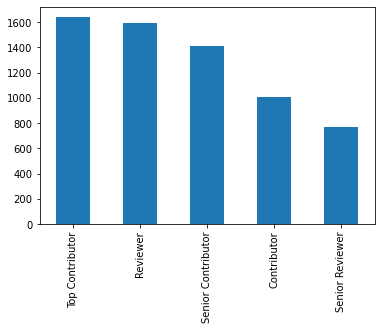

In [83]:
import matplotlib.pyplot as plt

df2["reviewer_rank"].value_counts().plot(kind = "bar")
plt.show()

In [84]:
clarity_color_table = pd.crosstab(index=df2["reviewer_rank"], columns=df2["stars"])

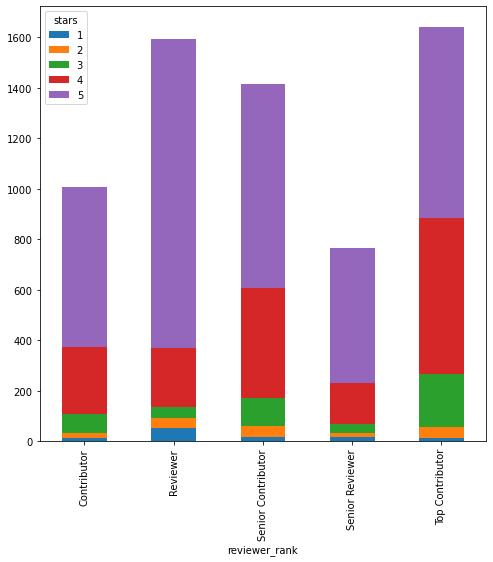

In [85]:
clarity_color_table.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

In [86]:
clarity_color_table1 = pd.crosstab(index=df2["reviewer_location"], columns=df2["stars"])

In [87]:
clarity_color_table1.plot(kind="bar", 
                 figsize=(20,8),
                 stacked=True)

Error in callback <function flush_figures at 0x000002383CA12AF0> (for post_execute):


KeyboardInterrupt: 

In [88]:
clarity_color_table1 = pd.crosstab(index=df2["accommodation_name"], columns=df2["stars"])

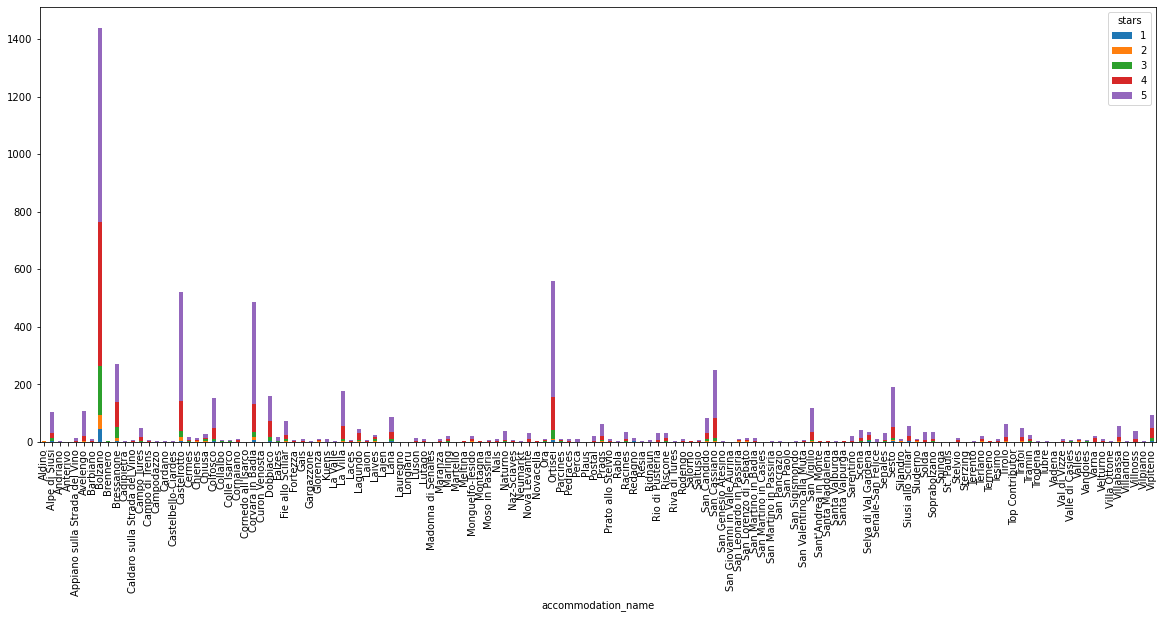

In [89]:
clarity_color_table1.plot(kind="bar", 
                 figsize=(20,8),
                 stacked=True)